In [1]:
import numpy as np
import sys
import pandas as pd
import yfinance as yf
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.svm import SVC

In [12]:
#importing any stock (I'm using AAPL) stock data and writing to pandas DF
ticker = input("Enter stock ticker: ") 
stock = yf.Ticker(f"{ticker}")
data = stock.history(period="1y")[::-1] #reversing the data so it's decreasing in time
# API for yahoo is currently down, pushing it as is for now

In [9]:
#If you want to get the data to a csv file
df.to_csv(f'{ticker}.csv')

In [7]:
#Basic EDA
# Display the first few rows of the dataframe
print(data.head())

# Get the summary statistics of the numerical columns
print(data.describe())

# Check the data types of each column
print(data.dtypes)

# Check the number of rows and columns in the dataframe
print(data.shape)

# Check for missing values in the dataframe
print(data.isnull().sum())


                                 Open        High         Low       Close  \
Date                                                                        
2025-01-10 00:00:00-05:00  240.009995  240.160004  233.000000  236.850006   
2025-01-08 00:00:00-05:00  241.919998  243.710007  240.050003  242.699997   
2025-01-07 00:00:00-05:00  242.979996  245.550003  241.350006  242.210007   
2025-01-06 00:00:00-05:00  244.309998  247.330002  243.199997  245.000000   
2025-01-03 00:00:00-05:00  243.360001  244.179993  241.889999  243.360001   

                             Volume  Dividends  Stock Splits  
Date                                                          
2025-01-10 00:00:00-05:00  61679400        0.0           0.0  
2025-01-08 00:00:00-05:00  37628900        0.0           0.0  
2025-01-07 00:00:00-05:00  40856000        0.0           0.0  
2025-01-06 00:00:00-05:00  45045600        0.0           0.0  
2025-01-03 00:00:00-05:00  40244100        0.0           0.0  
             Open  

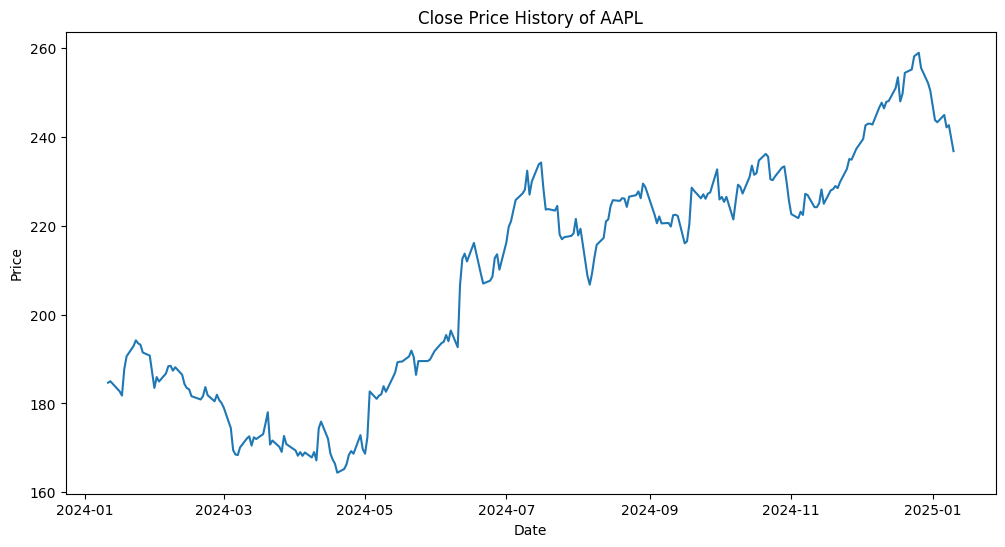

In [3]:
#Graphing the close vs time
plt.figure(figsize=(12,6))
plt.plot(data['Close'], label='Close Price history')
plt.title(f'Close Price History of {ticker}')
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()

In [13]:
#Getting the delta values
close = data['Close'].values
delta = np.zeros_like(close)
delta[1:] = np.where(close[:-1] != 0, (close[1:] / close[:-1]) - 1, 0)

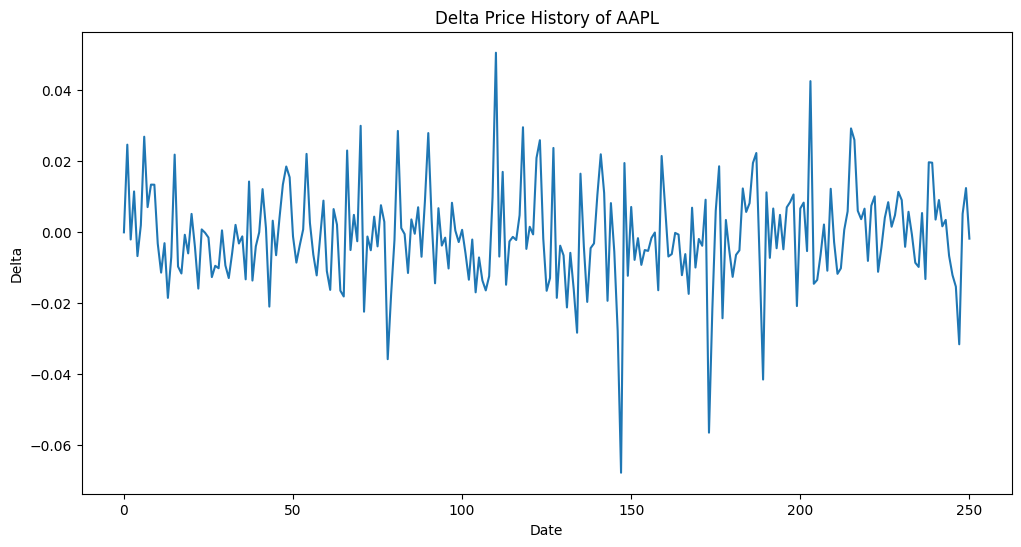

In [9]:
#Graphing the delta vs time
plt.figure(figsize=(12,6))
plt.plot(delta, label='Delta Price history')
plt.title(f'Delta Price History of {ticker}')
plt.xlabel('Date')
plt.ylabel('Delta')
plt.show()

/opt/anaconda3/envs/work/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Epoch: 50, Loss: 0.242845
Epoch: 100, Loss: 0.162702
Epoch: 150, Loss: 0.091792
Epoch: 200, Loss: 0.048780
Epoch: 250, Loss: 0.029441
Epoch: 300, Loss: 0.022464
Epoch: 350, Loss: 0.020362
Epoch: 400, Loss: 0.019782


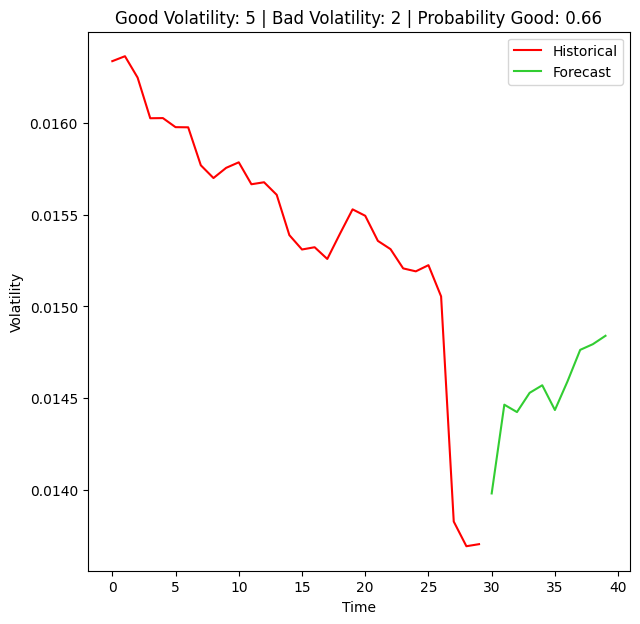

In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.svm import SVC

class NeuralNet(nn.Module):
    def __init__(self, inputs, outputs):
        super(NeuralNet, self).__init__()
        self.layer1 = nn.Linear(inputs, 50)
        self.layer2 = nn.Linear(50, outputs)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.layer1(x)
        x = self.relu(x)
        x = self.layer2(x)
        return x

class Normalize:
    def __init__(self, N):
        self.N = N

    def go(self, x):
        self.minx = []
        self.maxx = []
        y = np.array(x)
        for i in range(self.N):
            self.minx.append(np.min(y[:, i]))
            self.maxx.append(np.max(y[:, i]))
        # Add small epsilon to avoid division by zero
        denominator = np.array(self.maxx) - np.array(self.minx)
        denominator = np.where(denominator == 0, 1e-10, denominator)
        return (y - np.array(self.minx)) / denominator

    def back(self, x):
        y = np.array(x)
        return y * (np.array(self.maxx) - np.array(self.minx)) + np.array(self.minx)

def SplitData(p):
    def Problem(f):
        def Solve(*a, **b):
            inputs, outputs = f(*a, **b)
            I = int(p * len(inputs))
            trainX = inputs[:I]
            trainY = outputs[:I]
            testX = inputs[I:]
            testY = outputs[I:]  # Added test labels
            return trainX, trainY, testX, testY  # Modified to return test labels
        return Solve
    return Problem

def Volatility(close, window=100, output=30):
    ror = close[1:]/close[:-1] - 1.0
    volx = []
    for i in range(window, len(ror)):
        volx.append(np.std(ror[i-window:i]))
    return volx

@SplitData(0.7)
def VolDataset(vx, window=30, output=10):
    inputs = []
    outputs = []
    for i in range(window, len(vx)-output+1):
        inputs.append(vx[i-window:i])
        outputs.append(vx[i:i+output])
    return np.array(inputs), np.array(outputs)

@SplitData(0.7)
def GoodVsBadVol(close, window=100, output=30):
    cr = lambda x: np.prod([(1 + r) for r in x]) - 1.0
    vin = []
    vout = []
    ror = close[1:]/close[:-1] - 1.0
    sror = ror[window:]
    svol = Volatility(close)
    
    # Ensure we have both classes by using a threshold
    returns = []
    for i in range(window, len(svol)-output+1):
        ret = cr(sror[i:i+output])
        returns.append(ret)
    
    threshold = np.median(returns)  # Use median as threshold
    
    for i in range(len(returns)):
        vin.append(svol[i:i+window])
        vout.append(1 if returns[i] > threshold else 0)
    
    return np.array(vin), np.array(vout)

vx = Volatility(close)

vin, vout, vtest, vtest_out = VolDataset(vx)  # Modified to receive test labels

nin = Normalize(30)
nout = Normalize(10)
ntest = Normalize(30)
nsvin = Normalize(100)
nsvtest = Normalize(100)

normIN = nin.go(vin)
normOUT = nout.go(vout)
normTEST = ntest.go(vtest)

svin, svout, svtest, svtest_out = GoodVsBadVol(close)  # Modified to receive test labels

normSIN = nsvin.go(svin)
normSTEST = nsvtest.go(svtest)

# Check if we have both classes
unique_classes = np.unique(svout)
if len(unique_classes) < 2:
    raise ValueError("Dataset needs samples from both classes. Current classes:", unique_classes)

model = SVC(kernel='linear', probability=True)
model.fit(normSIN, svout)

goodbad = model.predict(normSTEST)
gbprob = model.predict_proba(normSTEST)

good = sum([1 for i in goodbad if i == 1])
bad = sum([1 for i in goodbad if i == 0])
goodClass = np.mean(gbprob[:, 1])  # Changed to use the positive class probability

# Neural Network part
IN = torch.stack([torch.tensor(i, dtype=torch.float32) for i in normIN])
OUT = torch.stack([torch.tensor(i, dtype=torch.float32) for i in normOUT])
TEST = torch.stack([torch.tensor(i, dtype=torch.float32) for i in normTEST])

lr = 0.0001

nmodel = NeuralNet(30, 10)
criterion = nn.MSELoss()
optimizer = optim.Adam(nmodel.parameters(), lr=lr)

epochs = 400

for epoch in range(epochs):
    output = nmodel(IN)
    loss = criterion(output, OUT)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if (epoch + 1) % 50 == 0:  # Print only every 50 epochs
        print(f"Epoch: {epoch+1}, Loss: {loss.item():.6f}")

with torch.no_grad():
    testout = nmodel(TEST)

forecast = testout.numpy()
forecast = nout.back(forecast)
forecast = forecast[-1]

plotvol = vx[-30:]
xvol = range(len(plotvol))
fvol = range(len(plotvol), len(plotvol)+len(forecast))

fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(111)

title = f'Good Volatility: {good} | Bad Volatility: {bad} | Probability Good: {goodClass:.2f}'

ax.set_title(title)
ax.set_xlabel('Time')
ax.set_ylabel('Volatility')
ax.plot(xvol, plotvol, color='red', label='Historical')
ax.plot(fvol, forecast, color='limegreen', label='Forecast')
ax.legend()

plt.show()

In [16]:
# Value at Risk and expected shortfall

# Define the number of days
n = input("Enter number of holding days")
# Value at Risk


# Calculate the value at risk
var = np.percentile(forecast, 5)

# Print the value at risk
print(f"Value at Risk for {n} days: {var}")

# Expected Shortfall

# Calculate the expected shortfall
expected_shortfall = np.mean(forecast[forecast <= var])

# Print the expected shortfall
print(f"Expected Shortfall for {n} days: {expected_shortfall}")




Value at Risk for 5 days: 0.014180654194751336
Expected Shortfall for 5 days: 0.01398110639544943
